IMAP-TDIA Code Base Zachary Robbins and Chonggang Xu
All code here in is distributed under an OSS License © 2022. Triad National Security, LLC. All rights reserved. This program was produced under U.S. Government contract 89233218CNA000001 for Los Alamos National Laboratory (LANL), which is operated by Triad National Security, LLC for the U.S. Department of Energy/National Nuclear Security Administration. All rights in the program are reserved by Triad National Security, LLC, and the U.S. Department of Energy/National Nuclear Security Administration. The Government is granted for itself and others acting on its behalf a nonexclusive, paid-up, irrevocable worldwide license in this material to reproduce, prepare derivative works, distribute copies to the public, perform publicly and display publicly, and to permit others to do so.

And a BSD license: This program is open source under the BSD-3 License. Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer. 2.Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution. 3.Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.
THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

### Median Insect Growth. 
This script uses the python package Pymc3 to fit the growth curve required for each stage of insect development from published rates of development in relation to temperature. It fits each growth curve using a Hamiltonian sampler. Graphs are produced for the runs and the resulting curves, these are used in the papers supplemental. 

In [2]:
import pymc3 as pm
import numpy as np
import theano.tensor as tt
import pandas as pd
import matplotlib as plt
import warnings
warnings.filterwarnings('ignore')

## Eggs

Each stage follows the same process of parameter estimation. Code documentation for Eggs is the same for subsequent processes.

In [78]:
### Temp from Miller and Keen 1960 
Temp=np.array([53,55,60,70,90])
## F to C
TempE=(Temp-32)*(5/9)
print(TempE)
## Length to duration
TimeE=np.array([114*8,57*8,40*8,7*8,7*8])
## As a Rate
OutputE=1/TimeE
np.mean(OutputE)

print("Sigma normal")
sigma=np.mean(OutputE)*.1
print(np.mean(sigma))
meanE=np.log((OutputE**2)/(np.sqrt((OutputE**2)+(sigma**2))) )
sigmaEprime=np.sqrt(np.log(1+((sigma**2)/(OutputE**2))))
#log(.00000007)
print("Sigma Prime")
print(np.mean(sigmaEprime))

[11.66666667 12.77777778 15.55555556 21.11111111 32.22222222]
Sigma normal
0.0008425751879699248
Sigma Prime
0.2822987564652529


In [6]:
Egg_Model=pm.Model()
with Egg_Model:
    ### Tight parameter around the min and max temp
    TmE=pm.Normal("TmE",mu=38.889,sigma=1.0)
    Tmb=pm.Normal("Tmb",mu=10,sigma=1.0)
    ### Other parameters loose
    Rate= pm.Gamma("Rate",mu=.18,sigma=.18)
    k=pm.Normal("k",mu=1044.0,sigma=104)
    dm=pm.Gamma("dm",mu=10.00,sigma=1.00)
    dN=pm.Deterministic("dN",Rate*((((TempE-Tmb)**2)/(((TempE-Tmb)**2)+k))-tt.exp(-(TmE-(TempE-Tmb))/dm)))
    obs = pm.Normal('obs', mu=dN, sigma=.0008, observed=OutputE)
    step=pm.Metropolis(vars=[TmE,Tmb,Rate,k,dm])
 
    trace=pm.sample(20000,step,cores=2)


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [dm]
>Metropolis: [k]
>Metropolis: [Rate]
>Metropolis: [Tmb]
>Metropolis: [TmE]
Sampling 2 chains, 0 divergences: 100%|██████████████████████████████████████| 41000/41000 [00:45<00:00, 900.38draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


##### Trace Plot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026A7784EB48>,
      dtype=object)

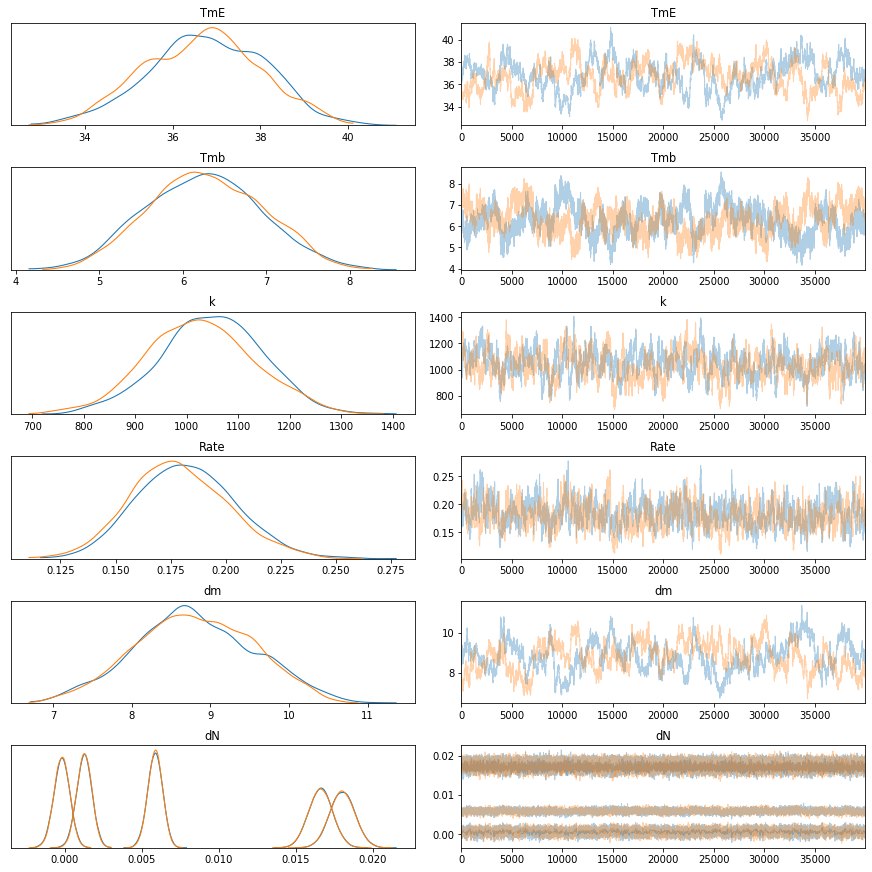

In [7]:
pm.traceplot(trace[10000:])

##### Summary 

In [18]:
pm.summary(trace[10000:]).round(4)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
TmE,37.150,0.852,35.766,38.857,0.135,0.097,40.0,39.0,40.0,80.0,1.05
Tmb,6.238,0.438,5.443,7.093,0.065,0.046,45.0,45.0,45.0,97.0,1.05
k,1079.101,105.391,876.742,1268.675,13.937,9.906,57.0,57.0,58.0,120.0,1.02
Rate,0.184,0.024,0.141,0.231,0.003,0.002,67.0,67.0,66.0,149.0,1.02
dm,8.877,0.495,7.864,9.721,0.085,0.061,34.0,34.0,34.0,110.0,1.11
dN[0],-0.000,0.001,-0.001,0.001,0.000,0.000,164.0,164.0,165.0,382.0,1.02
dN[1],0.001,0.000,0.000,0.002,0.000,0.000,214.0,214.0,214.0,640.0,1.02
dN[2],0.006,0.000,0.005,0.006,0.000,0.000,1235.0,1235.0,1230.0,4046.0,1.00
dN[3],0.016,0.001,0.015,0.018,0.000,0.000,307.0,307.0,307.0,1092.0,1.01
dN[4],0.018,0.001,0.017,0.020,0.000,0.000,3940.0,3940.0,3934.0,8821.0,1.00


##### Plotting Variables

In [19]:
## Load in variables from trace 
TmB=trace['Tmb']
TmE=trace['TmE']
k=trace['k']
Rate=trace['Rate']
dm=trace['dm']
## Create a range of Temps 
Temp=np.array(list(range(12,36)))
FakeTemps=Temp
## Store outputs 
MrList=[]
cols=str(list(range(12,36)))
### Loop thorugh rate 
prac=len(TmB)*.1
for i in list(range(1,len(TmB))):
    Mr=8*Rate[i]*((((Temp-TmB[i])**2)/(((Temp-TmB[i])**2)+k[i]))-np.exp(-(TmE[i]-(Temp-TmB[i]))/dm[i]))
    MrList.append(Mr)
df = pd.DataFrame(MrList)
### Looking at the 95% CI 


MR=df.quantile(.5,axis=0)
LR=df.quantile(.025,axis=0)
UR=df.quantile(.975,axis=0)


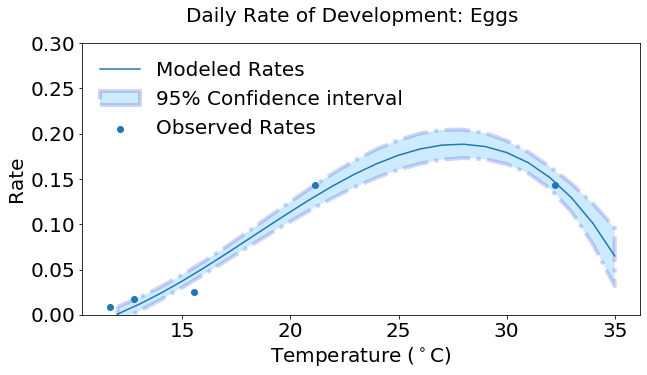

In [20]:
### Create a figure 
plt.pyplot.figure(figsize=(10,5))
plt.pyplot.suptitle('Daily Rate of Development: Eggs',fontsize=20)
plt.pyplot.plot(FakeTemps,MR,label="Modeled Rates")
plt.pyplot.fill_between(FakeTemps,LR, UR,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, linestyle='dashdot', antialiased=True,Label="95% Confidence interval")
plt.pyplot.scatter(TempE,OutputE*8,label="Observed Rates")
plt.pyplot.ylabel("Rate",fontsize=20)
plt.pyplot.ylim(0,.3)
plt.pyplot.xlabel("Temperature ($^\circ$C)",fontsize=20)
plt.pyplot.tick_params(labelsize=20)
plt.pyplot.legend(frameon=False,fontsize=20)

Duration

(<matplotlib.legend.Legend at 0x1f1c1ecb8c8>,)

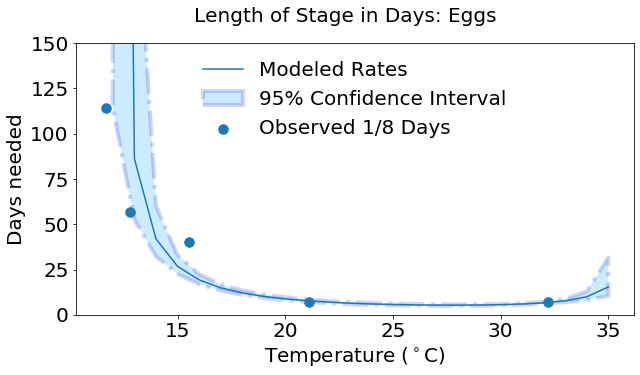

In [21]:
## Duration is the inverse of rate 
FakeTemps=np.array(list(range(12,36)))
plt.pyplot.figure(figsize=(10,5))
LR[LR<0.0]=.005
plt.pyplot.plot(FakeTemps,1/MR,label="Modeled Rates")
#plt.pyplot.plot(FakeTemps,1/LR,label="Modeled Rates")
#plt.pyplot.plot(FakeTemps,1/UR,label="Modeled Rates")
plt.pyplot.fill_between(FakeTemps,1/UR, 1/LR,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, linestyle='dashdot', antialiased=True,Label="95% Confidence Interval")
plt.pyplot.suptitle('Length of Stage in Days: Eggs',fontsize=20)
plt.pyplot.scatter(TempE,1/(OutputE*8),label="Observed 1/8 Days",s=90)
plt.pyplot.ylabel("Days needed",fontsize=20)
plt.pyplot.tick_params(labelsize=20)
plt.pyplot.xlabel("Temperature ($^\circ$C)",fontsize=20)
plt.pyplot.ylim(0,150)
plt.pyplot.legend(frameon=False,fontsize=20,loc="upper center"),
#print(LR)

### Larvae

In [125]:
### Temp from MK
Temp=np.array([51,60,70,85])
## F to C
TempL=(Temp-32)*(5/9)
## Length to duration
TimeL=np.array([296.9*8,29.69583*8,20*8,20*8])
## As a Rate
OutputL=1/TimeL
print(np.mean(OutputL))

print("Sigma normal")
sigma=np.mean(OutputL)*.1
print(np.mean(sigma))
meanE=np.log((OutputL**2)/(np.sqrt((OutputL**2)+(sigma**2))) )
sigmaEprime=np.sqrt(np.log(1+((sigma**2)/(OutputL**2))))
#log(.00000007)
print("Sigma Prime")
print(np.mean(sigmaEprime))

0.004282590598832773
Sigma normal
0.00042825905988327727
Sigma Prime
0.270295428429891


In [115]:
### Max temp between 95 and 100
### 36.4 +-1.3


L_Model=pm.Model()
with L_Model:
    ### Tight parameter around the min and max temp
    TmL=pm.Normal("TmE",mu=36.4,sigma=.5)
    TbL=pm.Normal("Tmb",mu=10,sigma=1.0)
    ### Other parameters loses
    RateL= pm.Gamma("Rate",mu=.016,sigma=.016)
    kL=pm.Normal("k",mu=800.0,sigma=80)
    dmL=pm.Gamma("dm",mu=6.00,sigma=.6)
    dNL=pm.Deterministic("dN",RateL*((((TempL-TbL)**2)/(((TempL-TbL)**2)+kL))-tt.exp(-(TmL-(TempL-TbL))/dmL)))
    #tt.printing.Print('dn')(dN)
    obs = pm.Normal('obs', mu=dNL, sigma=.0004, observed=OutputL)
    step=pm.Metropolis(vars=[TmL,TbL,RateL,kL,dmL])
 
    traceL=pm.sample(20000,step,cores=1)


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [dm]
>Metropolis: [k]
>Metropolis: [Rate]
>Metropolis: [Tmb]
>Metropolis: [TmE]
Sampling chain 1, 0 divergences: 100%|██████████████████████████████████████████| 20500/20500 [00:22<00:00, 915.57it/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F1C5C05908>,
      dtype=object)

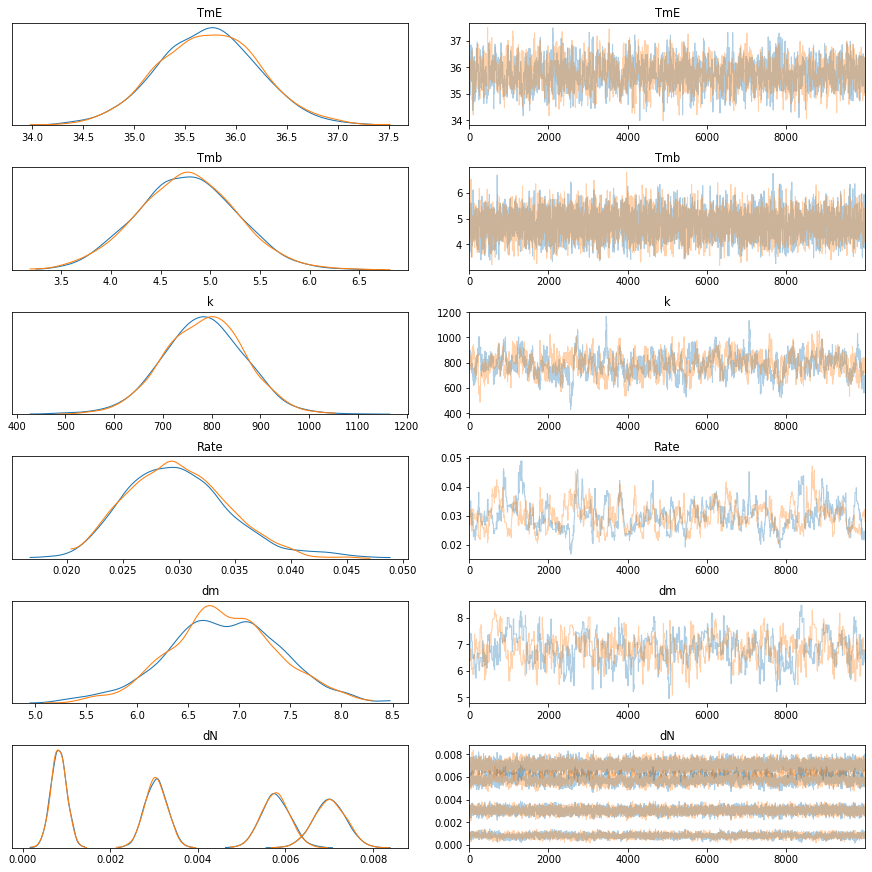

In [116]:
pm.traceplot(traceL[10000:])

In [118]:
pm.summary(traceL[10000:]).round(4)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
TmE,35.732,0.495,34.810,36.673,0.014,0.010,1238.0,1238.0,1240.0,1786.0,1.0
Tmb,4.768,0.495,3.823,5.673,0.009,0.006,3017.0,3017.0,3023.0,4296.0,1.0
k,784.489,83.512,626.771,937.104,4.831,3.420,299.0,299.0,300.0,539.0,1.0
Rate,0.030,0.005,0.022,0.038,0.000,0.000,168.0,168.0,169.0,271.0,1.0
dm,6.847,0.539,5.869,7.916,0.037,0.027,211.0,207.0,210.0,316.0,1.0
dN[0],0.001,0.000,0.000,0.001,0.000,0.000,886.0,886.0,888.0,1778.0,1.0
dN[1],0.003,0.000,0.003,0.004,0.000,0.000,3070.0,3070.0,3073.0,5766.0,1.0
dN[2],0.006,0.000,0.005,0.006,0.000,0.000,569.0,566.0,571.0,1535.0,1.0
dN[3],0.007,0.000,0.006,0.008,0.000,0.000,3769.0,3769.0,3768.0,7956.0,1.0


In [119]:
## Get variables from the trace
TmB=traceL['Tmb']
TmE=traceL['TmE']
k=traceL['k']
Rate=traceL['Rate']
dm=traceL['dm']
## Create vector of temps 
Temp=np.array(list(range(8,36)))
MrListL=[]

#cols=str(list(range(8,36)))
#print(cols)
prac=len(TmB)*.1
## Create vector relating values to temperature 
for i in list(range(1,len(TmB))):
    Mr=8*Rate[i]*((((Temp-TmB[i])**2)/(((Temp-TmB[i])**2)+k[i]))-np.exp(-(TmE[i]-(Temp-TmB[i]))/dm[i]))
    MrListL.append(Mr)
df = pd.DataFrame(MrListL)
## Get 95% CI 
MRL=df.quantile(.5,axis=0)
LRL=df.quantile(.025,axis=0)
URL=df.quantile(.975,axis=0)



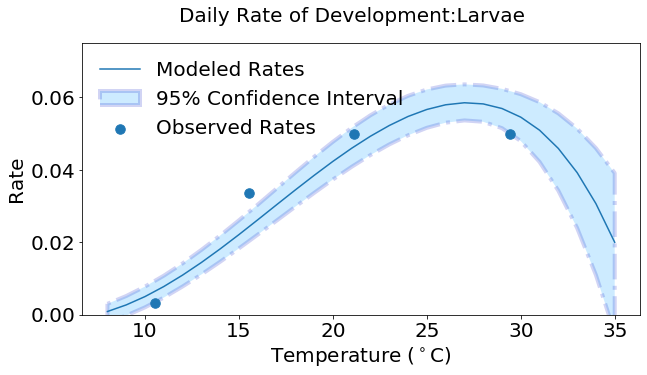

In [120]:
## Plotting rate 
Temp=np.array(list(range(8,36)))
plt.pyplot.figure(figsize=(10,5))
plt.pyplot.suptitle('Daily Rate of Development:Larvae',fontsize=20)
plt.pyplot.plot(Temp,MRL,label="Modeled Rates")
plt.pyplot.fill_between(Temp,LRL, URL,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, linestyle='dashdot', antialiased=True,Label="95% Confidence Interval")
plt.pyplot.scatter(TempL,OutputL*8,label="Observed Rates",s=90)
plt.pyplot.ylabel("Rate",fontsize=20)
plt.pyplot.tick_params(labelsize=20)
plt.pyplot.ylim(0,.075)
plt.pyplot.xlabel("Temperature ($^\circ$C)",fontsize=20)
plt.pyplot.legend(frameon=False,fontsize=20,loc="upper left")

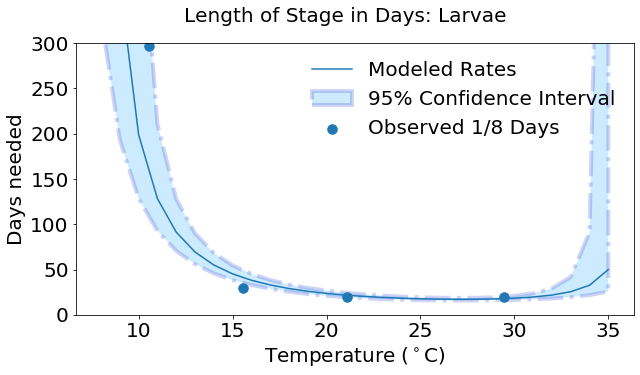

In [121]:
## Plot duration (inverse of rate )
FakeTemps=np.array(list(range(8,36)))
plt.pyplot.figure(figsize=(10,5))
LRL[LRL<0.0]=.001
MRL[MRL<0.0]=.001
URL[URL<0.0]=.001
plt.pyplot.plot(FakeTemps,1/MRL,label="Modeled Rates")
#plt.pyplot.plot(FakeTemps,1/LR,label="Modeled Rates")
#plt.pyplot.plot(FakeTemps,1/UR,label="Modeled Rates")
plt.pyplot.fill_between(FakeTemps,1/URL, 1/LRL,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, linestyle='dashdot', antialiased=True,Label="95% Confidence Interval")
plt.pyplot.suptitle('Length of Stage in Days: Larvae',fontsize=20)
plt.pyplot.scatter(TempL,1/(OutputL*8),label="Observed 1/8 Days",s=90)
plt.pyplot.ylabel("Days needed",fontsize=20)
plt.pyplot.tick_params(labelsize=20)
plt.pyplot.xlabel("Temperature ($^\circ$C)",fontsize=20)
plt.pyplot.ylim(0,300)
plt.pyplot.legend(frameon=False,fontsize=20)


### Pre-pupae


In [122]:
### Temp from MK
Temp=np.array([50,55,60,65,74])
## F to C
TempPP=(Temp-32)*(5/9)
## Length to duration
TimePP=np.array([117*8,7*8,4*8,3*8,2*8])
## As a Rate
OutputPP=1/TimePP
print(np.mean(OutputPP))

print("Sigma normal")
sigma=np.mean(OutputPP)*.1
print(np.mean(sigma))
meanE=np.log((OutputPP**2)/(np.sqrt((OutputPP**2)+(sigma**2))) )
sigmaEprime=np.sqrt(np.log(1+((sigma**2)/(OutputPP**2))))
#log(.00000007)
print("Sigma Prime")
print(np.mean(sigmaEprime))

0.03086843711843712
Sigma normal
0.003086843711843712
Sigma Prime
0.37770379167529766


In [127]:
PP_Model=pm.Model()
with PP_Model:
    ### Tight parameter around the min and max temp
    TmPP=pm.Normal("TmE",mu=36.4,sigma=1.0)
    TbPP=pm.Normal("Tmb",mu=10.0,sigma=1.0)
    ### Other parameters 
    RatePP= pm.Gamma("Rate",mu=.2313,sigma=.023)
    kPP=pm.Gamma("k",mu=431.0,sigma=43)
    dmPP=pm.Gamma("dm",mu=11.30,sigma=1.13)
    dN=pm.Deterministic("dN",RatePP*((((TempPP-TbPP)**2)/(((TempPP-TbPP)**2)+kPP))-tt.exp(-(TmPP-(TempPP-TbPP))/dmPP)))
      
    #tt.printing.Print('dn')(dN)
    obs = pm.Normal('obs', mu=dN, sigma=.0031, observed=OutputPP)
    step=pm.Metropolis(vars=[TmPP,TbPP,RatePP,kPP,dmPP])
 
    tracePP=pm.sample(20000,step,cores=1)


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [dm]
>Metropolis: [k]
>Metropolis: [Rate]
>Metropolis: [Tmb]
>Metropolis: [TmE]
Sampling chain 1, 0 divergences: 100%|██████████████████████████████████████████| 20500/20500 [00:23<00:00, 891.21it/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F1C9EFF2C8>,
      dtype=object)

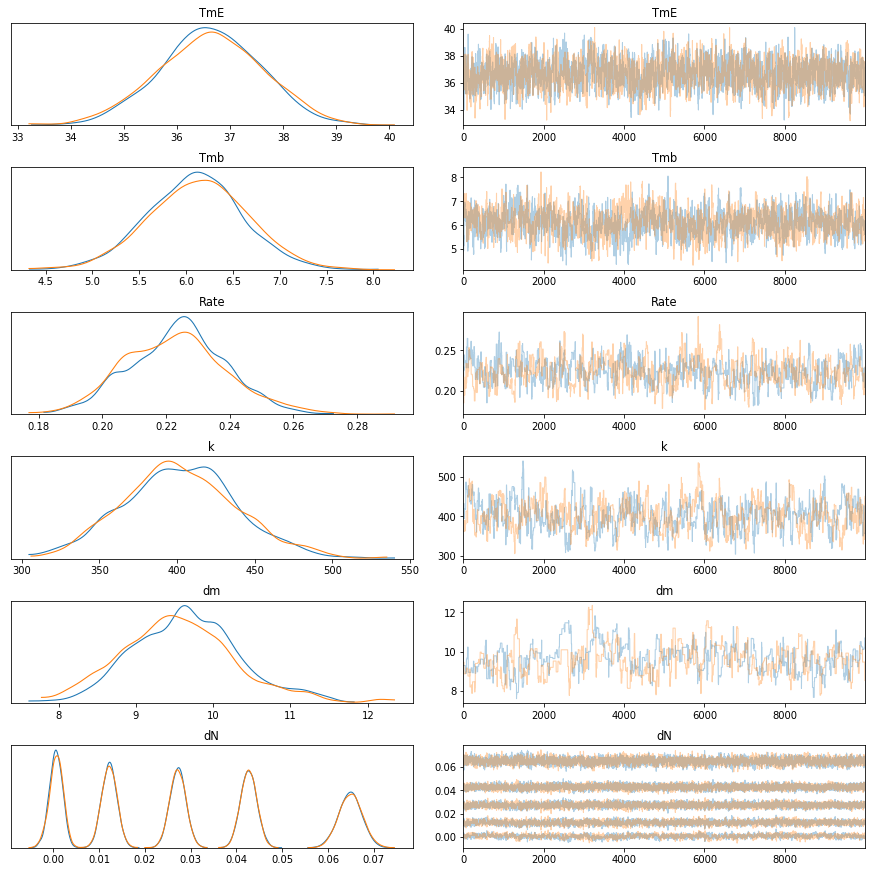

In [49]:
pm.traceplot(tracePP[10000:])

In [50]:
pm.summary(tracePP[10000:]).round(4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
TmE,36.637,0.972,34.846,38.473,0.029,0.021,1090.0,1090.0,1090.0,1993.0,1.00
Tmb,6.116,0.518,5.157,7.121,0.027,0.019,370.0,370.0,369.0,1218.0,1.01
Rate,0.223,0.015,0.196,0.254,0.001,0.001,293.0,293.0,294.0,501.0,1.01
k,402.385,36.563,337.455,475.399,2.375,1.682,237.0,237.0,238.0,417.0,1.01
dm,9.613,0.725,8.116,10.881,0.077,0.055,88.0,88.0,89.0,165.0,1.02
dN[0],0.001,0.001,-0.002,0.003,0.000,0.000,483.0,483.0,490.0,911.0,1.01
dN[1],0.012,0.002,0.009,0.015,0.000,0.000,1766.0,1766.0,1767.0,3761.0,1.00
dN[2],0.027,0.002,0.024,0.031,0.000,0.000,2186.0,2181.0,2185.0,4673.0,1.00
dN[3],0.043,0.002,0.039,0.046,0.000,0.000,2315.0,2305.0,2317.0,6503.0,1.00
dN[4],0.065,0.003,0.060,0.070,0.000,0.000,1670.0,1662.0,1674.0,3705.0,1.00


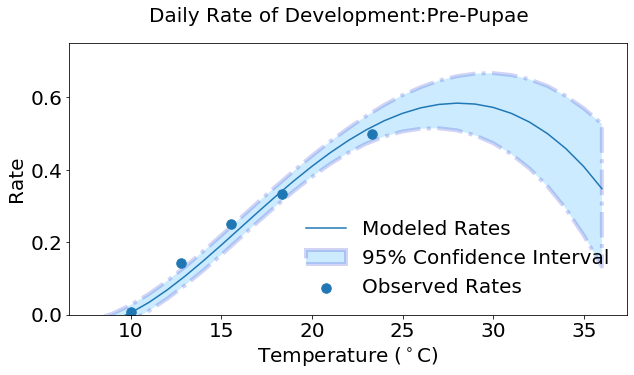

In [52]:
TmB=tracePP['Tmb']
TmE=tracePP['TmE']
k=tracePP['k']
Rate=tracePP['Rate']
dm=tracePP['dm']
Temp=np.array(list(range(8,37)))
MrListPP=[]
cols=str(list(range(8,37)))
#print(cols)
prac=len(TmB)*.1
for i in list(range(1,len(TmB))):
    Mr=8*Rate[i]*((((Temp-TmB[i])**2)/(((Temp-TmB[i])**2)+k[i]))-np.exp(-(TmE[i]-(Temp-TmB[i]))/dm[i]))
    MrListPP.append(Mr)
df = pd.DataFrame(MrListPP)
MRPP=df.quantile(.5,axis=0)
LRPP=df.quantile(.025,axis=0)
URPP=df.quantile(.975,axis=0)

plt.pyplot.figure(figsize=(10,5))
plt.pyplot.suptitle('Daily Rate of Development:Pre-Pupae',fontsize=20)
plt.pyplot.plot(Temp,MRPP,label="Modeled Rates")
plt.pyplot.fill_between(Temp,LRPP, URPP,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, linestyle='dashdot', antialiased=True,Label="95% Confidence Interval")
plt.pyplot.scatter(TempPP,OutputPP*8,label="Observed Rates",s=90)
plt.pyplot.ylabel("Rate",fontsize=20)
plt.pyplot.ylim(0,.75)
plt.pyplot.tick_params(labelsize=20)
#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)
plt.pyplot.xlabel("Temperature ($^\circ$C)",fontsize=20)
plt.pyplot.legend(frameon=False,fontsize=20)

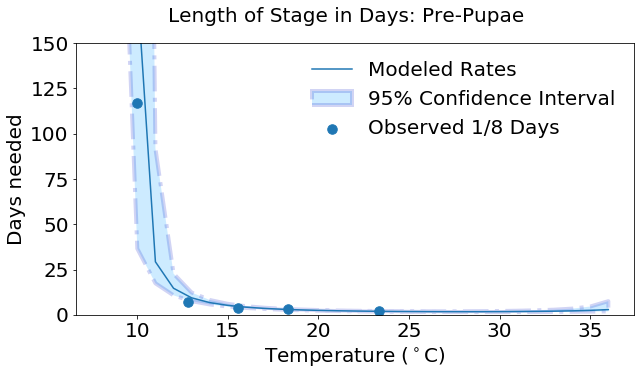

In [53]:
FakeTemps=np.array(list(range(8,37)))
plt.pyplot.figure(figsize=(10,5))
LRPP[LRPP<0.0]=.001
MRPP[MRPP<0.0]=.001
URPP[URPP<0.0]=.001
plt.pyplot.plot(FakeTemps,1/MRPP,label="Modeled Rates")
#plt.pyplot.plot(FakeTemps,1/LR,label="Modeled Rates")
#plt.pyplot.plot(FakeTemps,1/UR,label="Modeled Rates")
plt.pyplot.fill_between(FakeTemps,1/URPP, 1/LRPP,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, linestyle='dashdot', antialiased=True,Label="95% Confidence Interval")
plt.pyplot.suptitle('Length of Stage in Days: Pre-Pupae',fontsize=20)
plt.pyplot.scatter(TempPP,1/(OutputPP*8),label="Observed 1/8 Days",s=90)
plt.pyplot.ylabel("Days needed",fontsize=20)
plt.pyplot.xlabel("Temperature ($^\circ$C)",fontsize=20)
plt.pyplot.ylim(0,150)
plt.pyplot.tick_params(labelsize=20)
plt.pyplot.legend(frameon=False,fontsize=20)


### Pupae 

In [126]:
### Temp from MK
Temp=np.array([50,55,60,65,74])
## F to C
TempP=(Temp-32)*(5/9)
## Length to duration
TimeP=np.array([51*8,24*8,12*8,6*8,6*8])
## As a Rate
OutputP=1/TimeP
print(np.mean(OutputP))

print(np.mean(OutputP))

print("Sigma normal")
sigma=np.mean(OutputP)*.1
print(np.mean(sigma))
meanE=np.log((OutputP**2)/(np.sqrt((OutputP**2)+(sigma**2))) )
sigmaEprime=np.sqrt(np.log(1+((sigma**2)/(OutputP**2))))
#log(.00000007)
print("Sigma Prime")
print(np.mean(sigmaEprime))

0.011948529411764705
0.011948529411764705
Sigma normal
0.0011948529411764707
Sigma Prime
0.18343526201301205


In [73]:
P_Model=pm.Model()
with P_Model:
    ### Tight parameter around the min and max temp
    TmP=pm.Normal("TmE",mu=33.0,sigma=1.0)
    TbP=pm.Normal("Tmb",mu=10.0,sigma=1.0)
    ### Other parameters loses
    RateP= pm.Gamma("Rate",mu=.05,sigma=.005)
    kP=pm.Gamma("k",mu=204,sigma=20)
    dmP=pm.Gamma("dm",mu=12,sigma=1.2)
    dN=pm.Deterministic("dN",RateP*((((TempP-TbP)**2)/(((TempP-TbP)**2)+kP))-tt.exp(-(TmP-(TempP-TbP))/dmP)))
    #tt.printing.Print('dn')(dN)
    obs = pm.Normal('obs', mu=dN, sigma=.001, observed=OutputP)
    step=pm.Metropolis(vars=[TmP,TbP,RateP,kP,dmP])
 
    #traceP=pm.sample(20000,tune=40000, target_accept=.85,cores=1)
    traceP=pm.sample(30000,step,cores=1)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [dm]
>Metropolis: [k]
>Metropolis: [Rate]
>Metropolis: [Tmb]
>Metropolis: [TmE]
Sampling chain 1, 0 divergences: 100%|██████████████████████████████████████████| 30500/30500 [01:13<00:00, 417.42it/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F1C5FD5D08>,
      dtype=object)

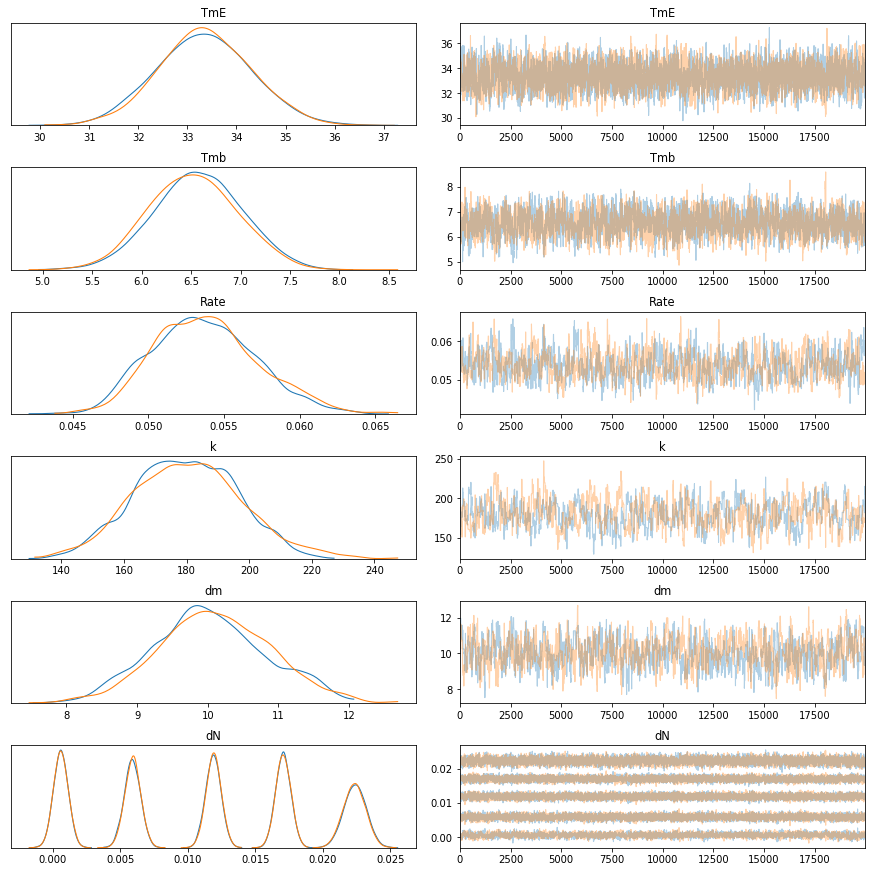

In [74]:
pm.traceplot(traceP[10000:])

In [75]:
pm.summary(traceP[10000:]).round(4)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
TmE,33.339,0.942,31.594,35.132,0.023,0.016,1676.0,1676.0,1673.0,3358.0,1.00
Tmb,6.541,0.442,5.753,7.391,0.014,0.010,946.0,946.0,946.0,2230.0,1.00
Rate,0.054,0.003,0.048,0.060,0.000,0.000,443.0,443.0,446.0,816.0,1.00
k,179.920,16.682,150.153,211.564,1.047,0.741,254.0,254.0,255.0,520.0,1.01
dm,10.055,0.792,8.620,11.564,0.035,0.025,513.0,509.0,515.0,868.0,1.01
dN[0],0.001,0.001,-0.000,0.002,0.000,0.000,1355.0,1355.0,1351.0,3892.0,1.00
dN[1],0.006,0.001,0.005,0.007,0.000,0.000,4426.0,4426.0,4420.0,7636.0,1.00
dN[2],0.012,0.001,0.011,0.013,0.000,0.000,4623.0,4583.0,4613.0,11012.0,1.00
dN[3],0.017,0.001,0.016,0.018,0.000,0.000,3609.0,3596.0,3612.0,9687.0,1.00
dN[4],0.022,0.001,0.021,0.024,0.000,0.000,3209.0,3209.0,3212.0,7050.0,1.00


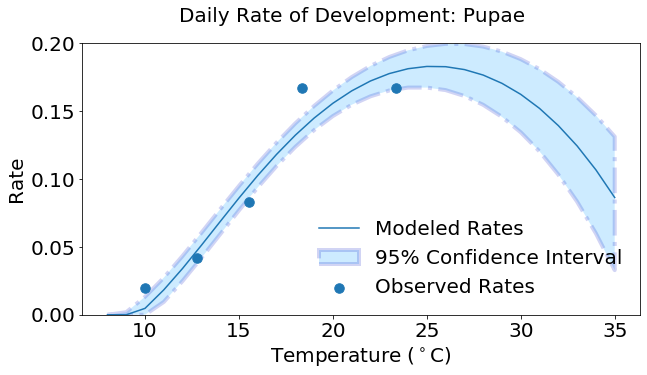

In [76]:
TmB=traceP['Tmb']
TmE=traceP['TmE']
k=traceP['k']
Rate=traceP['Rate']
dm=traceP['dm']
Temp=np.array(list(range(8,36)))
MrListP=[]
cols=str(list(range(8,6)))
#print(cols)
prac=len(TmB)*.1
for i in list(range(1,len(TmB))):
    Mr=8*Rate[i]*((((Temp-TmB[i])**2)/(((Temp-TmB[i])**2)+k[i]))-np.exp(-(TmE[i]-(Temp-TmB[i]))/dm[i]))
    MrListP.append(Mr)
df = pd.DataFrame(MrListP)
MRP=df.quantile(.5,axis=0)
LRP=df.quantile(.025,axis=0)
URP=df.quantile(.975,axis=0)
LRP[LRP<=0.0]=.00001
URP[URP<=0.0]=.00001
MRP[MRP<=0.0]=.00001
plt.pyplot.figure(figsize=(10,5))
plt.pyplot.suptitle('Daily Rate of Development: Pupae',fontsize=20)
plt.pyplot.plot(Temp,MRP,label="Modeled Rates")
plt.pyplot.fill_between(Temp,LRP, URP,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, linestyle='dashdot', antialiased=True,Label="95% Confidence Interval")
plt.pyplot.scatter(TempP,OutputP*8,label="Observed Rates",s=90)
plt.pyplot.ylabel("Rate",fontsize=20)
plt.pyplot.ylim(0,.2)
plt.pyplot.tick_params(labelsize=20)
plt.pyplot.xlabel("Temperature ($^\circ$C)",fontsize=20)
plt.pyplot.legend(frameon=False,fontsize=20)

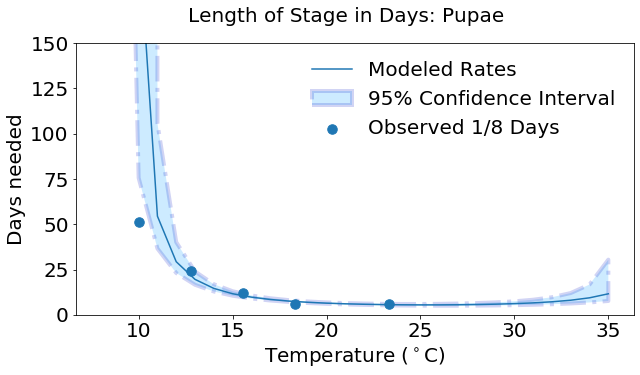

In [77]:

plt.pyplot.figure(figsize=(10,5))
#LR[LR<0.0]=.005
plt.pyplot.plot(Temp,1/MRP,label="Modeled Rates")
#plt.pyplot.plot(FakeTemps,1/LR,label="Modeled Rates")
#plt.pyplot.plot(FakeTemps,1/UR,label="Modeled Rates")
plt.pyplot.fill_between(Temp,1/URP, 1/LRP,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, linestyle='dashdot', antialiased=True,Label="95% Confidence Interval")
plt.pyplot.suptitle('Length of Stage in Days: Pupae',fontsize=20)
plt.pyplot.scatter(TempP,1/(OutputP*8),label="Observed 1/8 Days",s=90)
plt.pyplot.ylabel("Days needed",fontsize=20)
plt.pyplot.xlabel("Temperature ($^\circ$C)",fontsize=20)
plt.pyplot.tick_params(labelsize=20)
plt.pyplot.ylim(0,150)
plt.pyplot.legend(frameon=False,fontsize=20)
#print(LR)